In [1]:
import pandas as pd
import os
import sys
from collections import defaultdict
from pathlib import Path
import numpy as np
import json
import ipdb
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier

hoops_dir = Path("/Users/danielfriedman/Desktop/hoops")
data_dir = hoops_dir / "data"
sys.path.append(hoops_dir.as_posix())

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 30)

from pipeline import team_metadata, score_by_score, rank, playstats

In [2]:
seasons = [f"20{year}-{year+1}" for year in range(15, 22)]


# Pull Data

### Get Rankings

In [3]:
rbds = list()
for season in seasons:
    season_rbd = pd.read_csv(data_dir / "rankings" / (season + ".csv"))
    rbds.append(season_rbd)
rbd = pd.concat(rbds).reset_index(drop=True)
rbd.tail()


,team,ranking,date
31771,UTA,0.570852,2022-02-28
31772,MIA,0.684634,2022-02-28
31773,MEM,0.796213,2022-02-28
31774,GSW,0.894904,2022-02-28
31775,PHX,1.387793,2022-02-28


### Get Game State

In [4]:
sbss = list()
for season in seasons:
    season_sbs = pd.read_csv(data_dir / "score_by_score" / (season + ".csv"))
    sbss.append(season_sbs)
sbs = pd.concat(sbss).reset_index(drop=True)
sbs['points'] = (sbs['home_score'] + sbs['vis_score']) 
sbs['ppm'] = (sbs['home_score'] + sbs['vis_score']) /sbs['time']
sbs['mins'] = sbs['time'].apply(np.floor)
sbs['home_lead'] = sbs['home_score'] - sbs['vis_score']
sbs.tail()


,game_id,date,home,vis,time,home_score,vis_score,home_win,points,ppm,mins,home_lead
921290,22100629,2022-01-13,NOP,LAC,46.38,106,86,True,192,4.139715,46.0,20
921291,22100629,2022-01-13,NOP,LAC,46.65,108,86,True,194,4.158628,46.0,22
921292,22100629,2022-01-13,NOP,LAC,46.75,110,86,True,196,4.192513,46.0,24
921293,22100629,2022-01-13,NOP,LAC,47.28,113,86,True,199,4.208968,47.0,27
921294,22100629,2022-01-13,NOP,LAC,47.40,113,89,True,202,4.261603,47.0,24


### Get PlayStats

**TODO:** 3 point stats specifically?
**TODO:** get average time per possession for each team

In [5]:
pbds = list()
for season in seasons:
    try:
        season_pbd = pd.read_csv(data_dir / "playstats" / (season + ".csv"))
        season_pbd = season_pbd.loc[season_pbd['date'].notna()]
        pbds.append(season_pbd)
    except:
        pass
pbd = pd.concat(pbds).reset_index(drop=True)
pbd.rename(columns={'ppm': 'avg_ppm'}, inplace=True)
pbd_stats = [col for col in pbd.columns if col not in ['date', 'team']]
pbd.tail()


,date,team,pts,avg_ppm,poss,tov_rate,reb_rate,oreb_rate,dreb_rate,efpg,tsp,off_eff,def_eff
15713,2022-02-14,WAS,106.890909,2.210307,102.154545,0.129002,0.494738,0.291058,0.695533,0.523182,0.496256,1.048305,1.081858
15714,2022-02-16,WAS,106.821429,2.209156,102.017857,0.129532,0.495082,0.291691,0.695120,0.523188,0.496323,1.049049,1.080302
15715,2022-02-17,WAS,106.842105,2.209872,101.991228,0.129529,0.495254,0.291997,0.695717,0.523167,0.496469,1.049498,1.081075
15716,2022-02-25,WAS,107.017241,2.213797,101.939655,0.130083,0.494818,0.291588,0.694242,0.524948,0.498098,1.051779,1.080374
15717,2022-02-26,WAS,107.796610,2.220985,102.305085,0.130074,0.494219,0.291982,0.692585,0.526566,0.499478,1.054950,1.083609


### Merge

In [6]:
sbs_sub = sbs[['game_id', 'date', 'home', 'vis', 'home_win', 'time', 'mins', 'home_score', 'vis_score', 'home_lead', 'points', 'ppm']]
m = pd.merge(left=sbs_sub, right=rbd, left_on=['home', 'date'], right_on=['team', 'date']).rename(columns={'ranking':'home_ranking'}).drop(columns='team')
m = pd.merge(left=m, right=rbd, left_on=['vis', 'date'], right_on=['team', 'date']).rename(columns={'ranking':'vis_ranking'}).drop(columns='team')
m = pd.merge(left=m, right=pbd, left_on=['home', 'date'], right_on=['team', 'date']).rename(columns={stat: "home_"+stat for stat in pbd_stats}).drop(columns='team')
m = pd.merge(left=m, right=pbd, left_on=['home', 'date'], right_on=['team', 'date']).rename(columns={stat: "vis_"+stat for stat in pbd_stats}).drop(columns='team')
m['home_lead'] = m['home_score'] - m['vis_score']
m['mins'] = m['time'] // 1
m.tail()




,game_id,date,home,vis,home_win,time,mins,home_score,vis_score,home_lead,points,ppm,home_ranking,vis_ranking,home_pts,home_avg_ppm,home_poss,home_tov_rate,home_reb_rate,home_oreb_rate,home_dreb_rate,home_efpg,home_tsp,home_off_eff,home_def_eff,vis_pts,vis_avg_ppm,vis_poss,vis_tov_rate,vis_reb_rate,vis_oreb_rate,vis_dreb_rate,vis_efpg,vis_tsp,vis_off_eff,vis_def_eff
908006,22100629,2022-01-13,NOP,LAC,True,46.38,46.0,106,86,20,192,4.139715,-0.462198,-0.061781,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393
908007,22100629,2022-01-13,NOP,LAC,True,46.65,46.0,108,86,22,194,4.158628,-0.462198,-0.061781,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393
908008,22100629,2022-01-13,NOP,LAC,True,46.75,46.0,110,86,24,196,4.192513,-0.462198,-0.061781,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393
908009,22100629,2022-01-13,NOP,LAC,True,47.28,47.0,113,86,27,199,4.208968,-0.462198,-0.061781,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393
908010,22100629,2022-01-13,NOP,LAC,True,47.40,47.0,113,89,24,202,4.261603,-0.462198,-0.061781,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393


#### Empirical Means

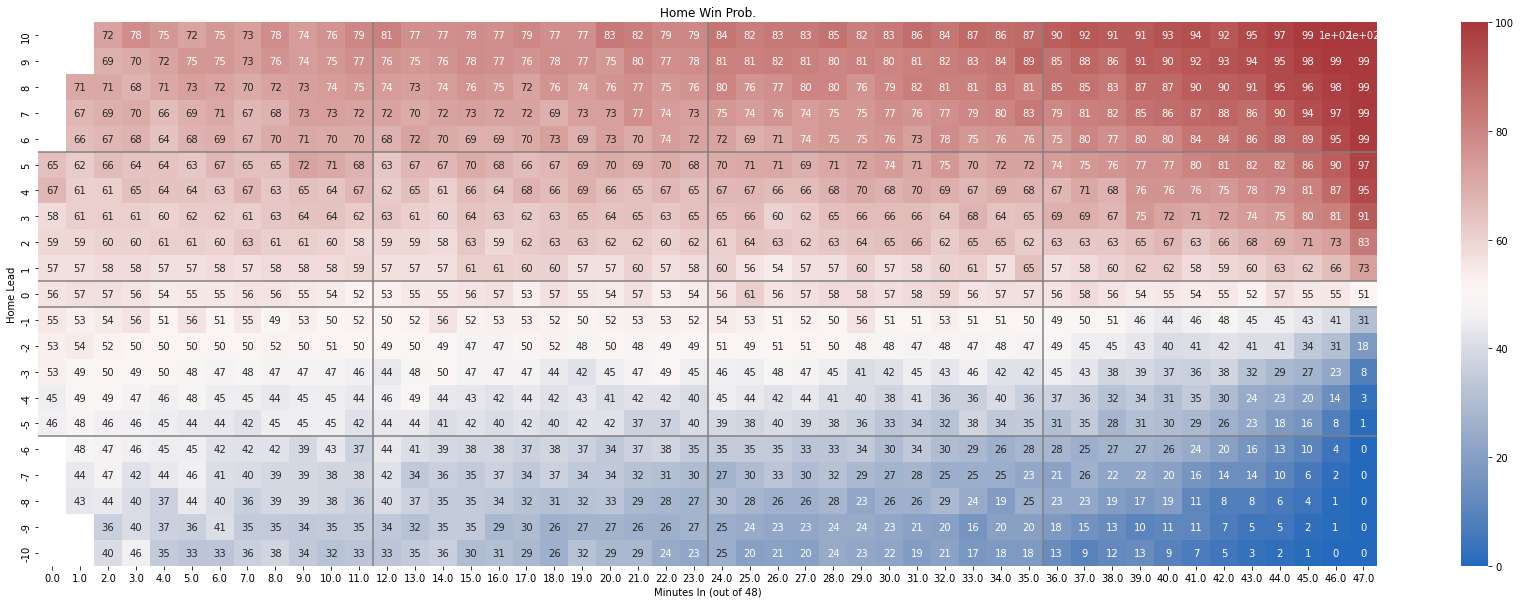

In [242]:
time_mod = 1
score_mod = 1

x = m.drop_duplicates(subset=['game_id', 'mins', 'home_lead']).groupby(["mins", "home_lead"]).agg({'home_win': ['count', 'mean']})['home_win'].reset_index().rename(columns={'mean':'win_pct'})
x['win_pct'] = (x['win_pct'] * 100).astype(int)
x = x.loc[x['count'] >= 50]
x = x.pivot(index='home_lead', columns='mins', values='win_pct')
x.index = np.array(list(x.index)) * score_mod
x.columns = np.array(list(x.columns)) * time_mod

fig, ax = plt.subplots(figsize=(30, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
ax.axhline(10, color='gray')
ax.axhline(11, color='gray')
ax.axhline(5, color='gray')
ax.axhline(16, color='gray')
sns.heatmap(x.loc[10:-10:-1, 0:47], annot=True, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Home Win Prob.");



___

# XGB

In [783]:
# mod = XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='logloss',
#     use_label_encoder=False,
#     min_child_weight=50,
#     colsample_bylevel=0.9,
#     subsample=0.9
# )

# params = [
#     {
#         'max_depth': [14],
#         'n_estimators': [300],
#         'eta': [.01],
#         'min_child_weight': [5],
#         'reg_lambda': [.5],
#         'gamma': [3],
#     }
# ]

# m_ = m.loc[(m['mins'] < 48)]
# X = m_[['home_ranking', 'vis_ranking', 'home_lead', 'mins']].to_numpy()
# y = m_['home_win'].astype(int).to_numpy()
# grid_search = GridSearchCV(mod, params, scoring="neg_log_loss", n_jobs=-1, cv=2)
# grid_result = grid_search.fit(X, y)
# best_params = grid_search.best_params_ # {'eta': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 50}
# mod = grid_search.best_estimator_
# print(grid_search.best_score_)
# print(best_params)


In [330]:
# cutoff = "2021-09-01"
# # features = [c for c in m.columns if c not in ['game_id', 'date', 'home', 'vis', 'home_win', 'time', 'home_score', 'vis_score']]
# # features = ['home_lead', 'mins', 'points', 'home_ranking', 'vis_ranking', 'home_off_eff', 'vis_off_eff', 'home_def_eff', 'vis_def_eff', 'home_avg_ppm', 'vis_avg_ppm', 'home_tsp', 'vis_tsp', ]
# features = ['home_lead', 'mins', 'ppm', 'home_ranking', 'vis_ranking', 'home_off_eff', 'vis_off_eff']
# m_ = m.loc[m['time'] < 48]
# X_train = m_.loc[m_['date'] <= cutoff, features].to_numpy()
# X_test = m_.loc[m_['date'] > cutoff, features].to_numpy()
# y_train = m_.loc[m_['date'] <= cutoff, 'home_win'].astype(int).to_numpy()
# y_test = m_.loc[m_['date'] > cutoff, 'home_win'].astype(int).to_numpy()

# mod = XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='logloss',
#     use_label_encoder=False,
#     ##
#     max_depth=8,
#     n_estimators=5000,
#     eta=.01,
#     min_child_weight=250,
#     reg_lambda=.5,
#     gamma=0,
#     max_delta_step=5
#     ##
# )

# mod.fit(X=X_train, y=y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0, early_stopping_rounds=10)
# results = mod.evals_result()
# train_loglosses = results['validation_0']['logloss']
# test_loglosses = results['validation_1']['logloss']

# fig, ax = plt.subplots(2, 1, figsize=(9, 10))
# sns.lineplot(x=range(len(train_loglosses)), y=train_loglosses, label="train", color='blue', ax=ax[0])
# sns.lineplot(x=range(len(test_loglosses)), y=test_loglosses, label="test", color='red', ax=ax[1])
# ax[0].grid()
# ax[1].grid()
# sns.despine()




In [326]:
# # Get dummy data
# mins = np.arange(0, 48)
# home_leads = np.arange(-10, 11)
# n_combos = len(mins)*len(home_leads)
# dummy_row = pd.DataFrame(m[features].mean()).T
# dummy_data = pd.concat([dummy_row]*n_combos).reset_index(drop=True)
# dummy_data['mins'] = np.tile(mins, len(home_leads))
# dummy_data['home_lead'] = np.repeat(home_leads, len(mins))
# dummy_data['home_ranking'] = 0
# dummy_data['vis_ranking'] = 0

# # Predict
# dummy_data['yhat'] = mod.predict_proba(dummy_data)[:,1]

# # Pivot
# panel = dummy_data.pivot(index='home_lead', columns='mins', values='yhat')

# # Plot
# fig, ax = plt.subplots(figsize=(20, 10))
# ax.axvline(12, color='gray')
# ax.axvline(24, color='gray')
# ax.axvline(36, color='gray')
# ax.axhline(10, color='gray')
# ax.axhline(11, color='gray')
# ax.axhline(5, color='gray')
# ax.axhline(16, color='gray')
# sns.heatmap(panel[::-1]*100, annot=True, cmap="vlag")
# ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


In [327]:
# # Get dummy data
# mins = np.arange(0, 48)
# home_leads = np.arange(-10, 11)
# n_combos = len(mins)*len(home_leads)
# dummy_row = pd.DataFrame(m[features].mean()).T
# dummy_data = pd.concat([dummy_row]*n_combos).reset_index(drop=True)
# dummy_data['mins'] = np.tile(mins, len(home_leads))
# dummy_data['home_lead'] = np.repeat(home_leads, len(mins))
# dummy_data['home_ranking'] = .5
# dummy_data['vis_ranking'] = -.5

# # Predict
# dummy_data['yhat'] = mod.predict_proba(dummy_data)[:,1]

# # Pivot
# panel = dummy_data.pivot(index='home_lead', columns='mins', values='yhat')

# # Plot
# fig, ax = plt.subplots(figsize=(20, 10))
# ax.axvline(12, color='gray')
# ax.axvline(24, color='gray')
# ax.axvline(36, color='gray')
# ax.axhline(10, color='gray')
# ax.axhline(11, color='gray')
# ax.axhline(5, color='gray')
# ax.axhline(16, color='gray')
# sns.heatmap(panel[::-1]*100, annot=True, cmap="vlag")
# ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


In [328]:
# # Get dummy data
# mins = np.arange(0, 48)
# home_leads = np.arange(-10, 11)
# n_combos = len(mins)*len(home_leads)
# dummy_row = pd.DataFrame(m[features].mean()).T
# dummy_data = pd.concat([dummy_row]*n_combos).reset_index(drop=True)
# dummy_data['mins'] = np.tile(mins, len(home_leads))
# dummy_data['home_lead'] = np.repeat(home_leads, len(mins))
# dummy_data['home_ranking'] = -.5
# dummy_data['vis_ranking'] = .5

# # Predict
# dummy_data['yhat'] = mod.predict_proba(dummy_data)[:,1]

# # Pivot
# panel = dummy_data.pivot(index='home_lead', columns='mins', values='yhat')

# # Plot
# fig, ax = plt.subplots(figsize=(20, 10))
# ax.axvline(12, color='gray')
# ax.axvline(24, color='gray')
# ax.axvline(36, color='gray')
# ax.axhline(10, color='gray')
# ax.axhline(11, color='gray')
# ax.axhline(5, color='gray')
# ax.axhline(16, color='gray')
# sns.heatmap(panel[::-1]*100, annot=True, cmap="vlag")
# ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");

In [329]:
# pd.Series(dict(zip(features, mod.feature_importances_))).sort_values(ascending=False).head(30)

___

In [416]:
# prevs = [5]
# for prev in prevs:
#     m[f'home_lead_prev_{prev}'] = m['home_lead'].shift(prev)
#     m.loc[m['game_id'].shift(prev) != m['game_id'], f'home_lead_prev_{prev}'] = np.nan
    

___

# FFNN

In [549]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Activation
from sklearn.preprocessing import StandardScaler


In [637]:
## Get features
# features = ['home_off_eff', 'vis_off_eff', 'home_def_eff', 'vis_def_eff', 'home_avg_ppm', 'vis_avg_ppm', 'home_tsp', 'vis_tsp']
features = ['home_lead', 'time_left', 'ppm', 'home_ranking', 'vis_ranking'] #, 'home_off_eff', 'vis_off_eff']
# features.extend([f'home_lead_prev_{prev}' for prev in prevs])

## Get training/test
cutoff = "2021-09-01"
m_ = m.loc[m['time'] < 48].dropna(axis=0).reset_index(drop=True).copy(deep=True)
m_['time_left'] = np.log(48-m_['time'])
X_train = m_.loc[m_['date'] <= cutoff, features].to_numpy()
X_test = m_.loc[m_['date'] > cutoff, features].to_numpy()
y_train = m_.loc[m_['date'] <= cutoff, 'home_win'].astype(int).to_numpy()
y_test = m_.loc[m_['date'] > cutoff, 'home_win'].astype(int).to_numpy()

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [667]:
import time 
s = time.time()
model = keras.Sequential()
model.add(keras.Input(shape=(X_train_scaled.shape[1],)))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(1, activation='sigmoid'))
print(model.summary())

opt = keras.optimizers.Adam(learning_rate=2.5e-6)
model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['binary_crossentropy', 'acc']
)

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(
    X_train_scaled,
    y_train,
    batch_size=64,
    epochs=500,
    validation_data=(X_test_scaled, y_test),
    callbacks=[callback],
    verbose=2
)
print(time.time() - s)


Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 16)                96        
_________________________________________________________________
dense_106 (Dense)            (None, 32)                544       
_________________________________________________________________
dense_107 (Dense)            (None, 8)                 264       
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 9         
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
11930/11930 - 6s - loss: 0.6978 - binary_crossentropy: 0.6978 - acc: 0.5979 - val_loss: 0.6711 - val_binary_crossentropy: 0.6711 - val_acc: 0.6778
Epoch 2/500
11930/11930 - 6s - loss: 0.6537 - binary_crossentropy: 0.6537 - acc: 0.7102 -

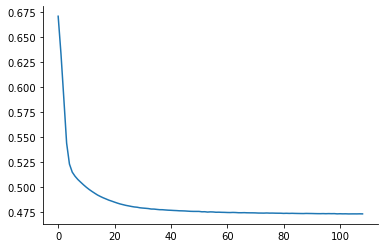

In [668]:
i=0
sns.lineplot(x=np.arange(len(history.history['val_loss'][-i:])), y=history.history['val_loss'][-i:])
sns.despine()

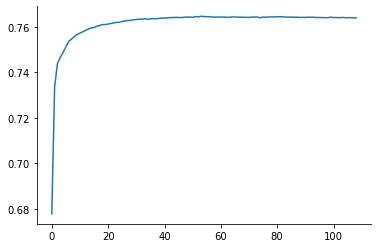

In [669]:
sns.lineplot(x=np.arange(len(history.history['val_acc'])), y=history.history['val_acc'])
sns.despine()

In [670]:
def get_win_probs_by_game_state(m, ss, home_ranking=0, vis_ranking=0, mins=np.arange(0, 48), home_leads=np.arange(-10, 11), mean_replacers=None):
    n_combos = len(mins)*len(home_leads)
    mean_replacers = mean_replacers if mean_replacers is not None else dict()
    dummy_row = pd.DataFrame(m[features].mean()).T
    for feature, value in mean_replacers.items():
        dummy_row.loc[0, feature] = value
    dummy_data = pd.concat([dummy_row]*n_combos).reset_index(drop=True)
    # dummy_data['time'] = np.tile(mins, len(home_leads))
    dummy_data['time_left'] = np.log(48-np.tile(mins, len(home_leads)))
    dummy_data['home_lead'] = np.repeat(home_leads, len(mins))
    dummy_data['home_ranking'] = home_ranking
    dummy_data['vis_ranking'] = vis_ranking
    dummy_data_scaled = ss.transform(dummy_data.to_numpy())
    dummy_data['yhat'] = model.predict(dummy_data_scaled)[:,0]
    dummy_data['time'] = np.tile(mins, len(home_leads))
    panel = dummy_data.pivot(index='home_lead', columns='time', values='yhat')
    return panel

    

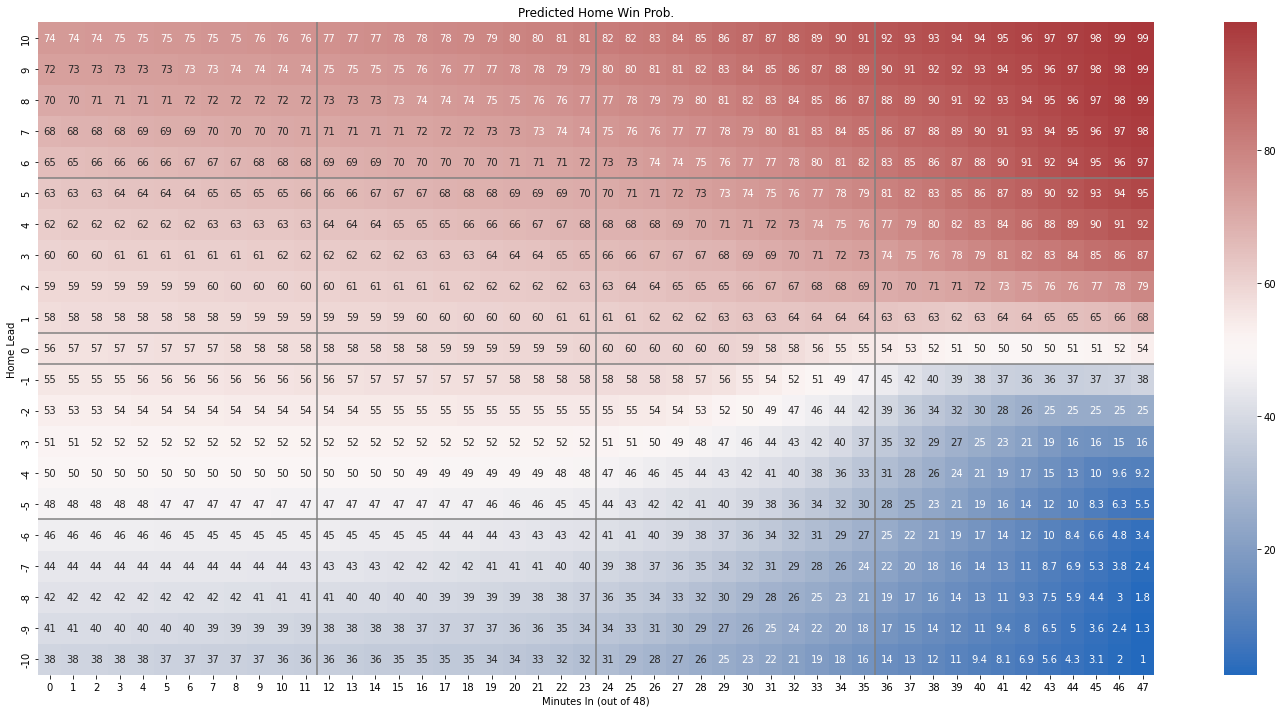

In [671]:
# Get win probs
panel_even = get_win_probs_by_game_state(m_, ss)

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_even[::-1]*100, annot=True, cmap="vlag")
else:
    sns.heatmap(panel_even[::-1]*100, annot=False, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


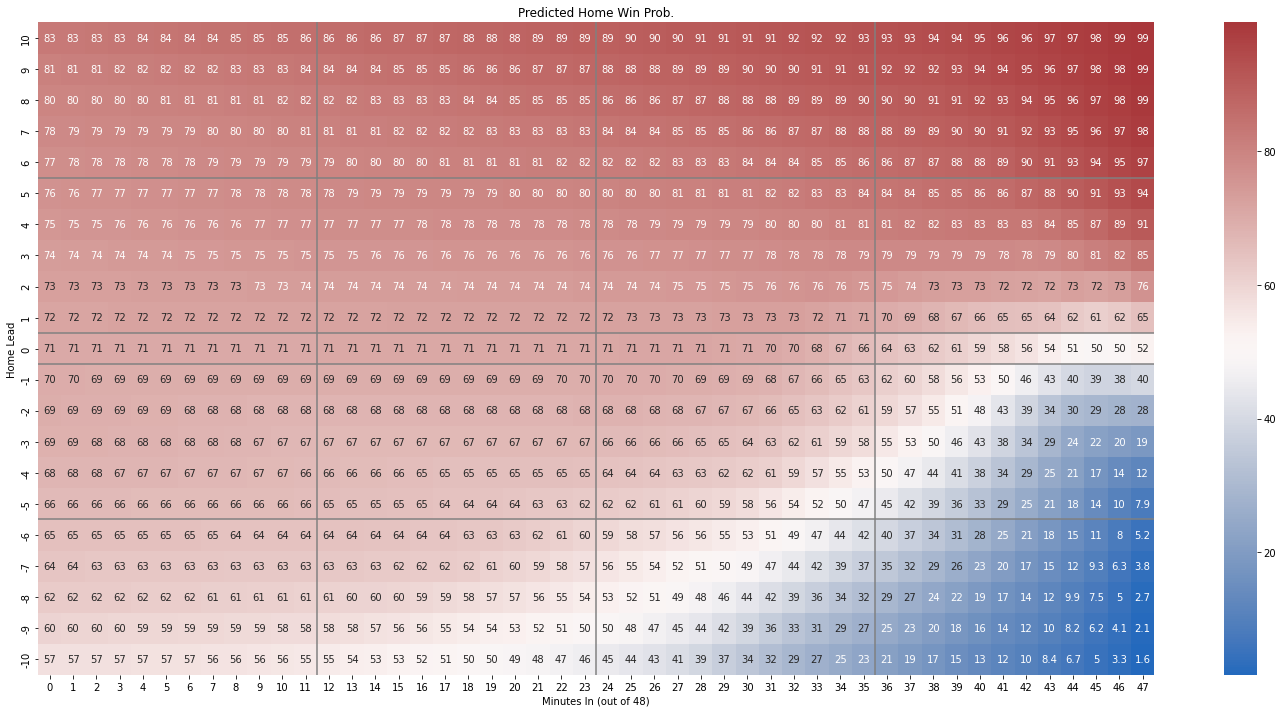

In [672]:
# Get win probs
panel_home_fav = get_win_probs_by_game_state(m_, ss, home_ranking=.5, vis_ranking=-.5)

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_home_fav[::-1]*100, annot=True, cmap="vlag")
else:
    sns.heatmap(panel_home_fav[::-1]*100, annot=False, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


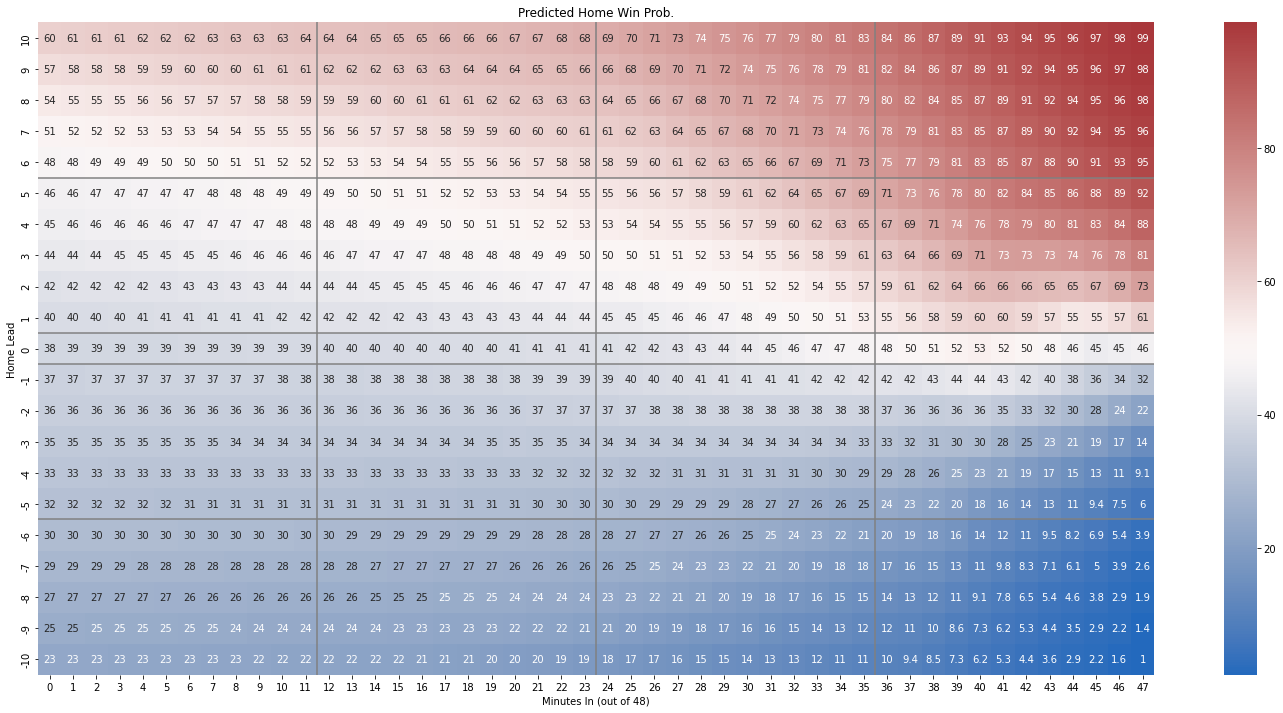

In [673]:
# Get win probs
panel_vis_fav = get_win_probs_by_game_state(m_, ss, home_ranking=-.5, vis_ranking=.5)

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_vis_fav[::-1]*100, annot=True, cmap="vlag")
else:
    sns.heatmap(panel_vis_fav[::-1]*100, annot=False, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


In [674]:
# # Plot
# fig, ax = plt.subplots(figsize=(25, 12))
# annot = False
# annot = True
# panel_diff = (panel_home_fav[::-1] - panel_even[::-1])*100
# vmax = max(-panel_diff.min().min(), panel_diff.max().max())
# if annot:
#     ax.axvline(12, color='gray')
#     ax.axvline(24, color='gray')
#     ax.axvline(36, color='gray')
#     ax.axhline(10, color='gray')
#     ax.axhline(11, color='gray')
#     ax.axhline(5, color='gray')
#     ax.axhline(16, color='gray')
#     sns.heatmap(panel_diff, annot=True, cmap="vlag", vmin=-vmax, vmax=vmax)
# else:
#     sns.heatmap(panel_diff, annot=False, cmap="vlag", vmin=-vmax, vmax=vmax)
# ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


____

In [675]:
sbs.loc[sbs['date'] >= "2022-02-25"].sample(5)

,game_id,date,home,vis,time,home_score,vis_score,home_win,points,ppm,mins,home_lead
895880,22100918,2022-02-27,POR,DEN,40.30,76,101,False,177,4.392060,40.0,-25
862937,22100907,2022-02-26,CLE,WAS,12.23,18,25,True,43,3.515944,12.0,-7
895794,22100918,2022-02-27,POR,DEN,6.17,12,10,False,22,3.565640,6.0,2
854743,22100917,2022-02-27,GSW,DAL,16.12,48,38,False,86,5.334988,16.0,10
896130,22100925,2022-02-28,OKC,SAC,39.12,97,104,False,201,5.138037,39.0,-7


In [676]:
game_sbs = sbs.loc[sbs['game_id'] == 22100907]
game_sbs

,game_id,date,home,vis,time,home_score,vis_score,home_win,points,ppm,mins,home_lead
862915,22100907,2022-02-26,CLE,WAS,0.00,0,0,True,0,NaN,0.0,0
862916,22100907,2022-02-26,CLE,WAS,0.63,0,2,True,2,3.174603,0.0,-2
862917,22100907,2022-02-26,CLE,WAS,1.63,2,2,True,4,2.453988,1.0,0
862918,22100907,2022-02-26,CLE,WAS,2.00,2,4,True,6,3.000000,2.0,-2
862919,22100907,2022-02-26,CLE,WAS,2.80,5,4,True,9,3.214286,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
863003,22100907,2022-02-26,CLE,WAS,47.52,88,86,True,174,3.661616,47.0,2
863004,22100907,2022-02-26,CLE,WAS,47.52,89,86,True,175,3.682660,47.0,3
863005,22100907,2022-02-26,CLE,WAS,47.78,90,86,True,176,3.683550,47.0,4
863006,22100907,2022-02-26,CLE,WAS,47.92,91,86,True,177,3.693656,47.0,5


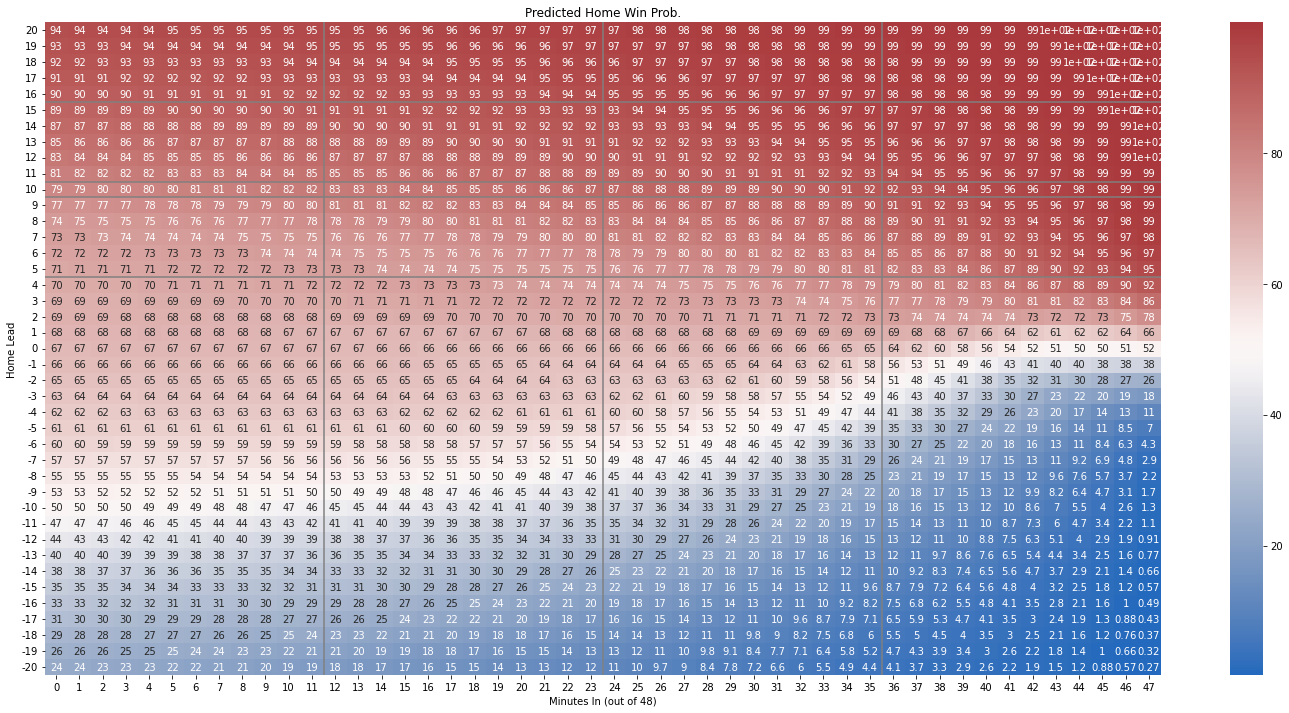

In [677]:
home = game_sbs.iloc[-1]['home']
vis = game_sbs.iloc[-1]['vis']
home_ranking = rbd.sort_values("date").groupby("team")['ranking'].last()[home]
vis_ranking = rbd.sort_values("date").groupby("team")['ranking'].last()[vis]
panel = get_win_probs_by_game_state(m_, ss, home_ranking=home_ranking, vis_ranking=vis_ranking, home_leads=np.arange(-20, 21))

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
ax.axhline(10, color='gray')
ax.axhline(11, color='gray')
ax.axhline(5, color='gray')
ax.axhline(16, color='gray')
sns.heatmap(panel[::-1]*100, annot=True, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");

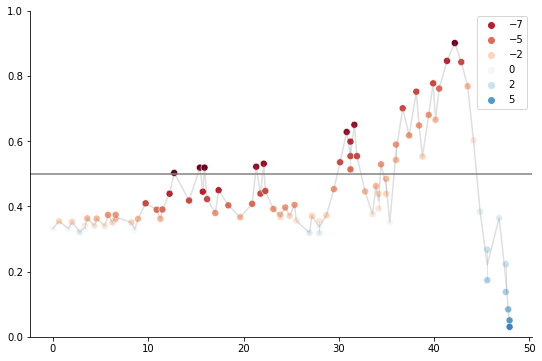

In [678]:
probs = list()
home_leads = list()
time = list()
for _, row in game_sbs.iterrows():
    probs.append(panel.loc[row['home_lead'], row['mins']])
    home_leads.append(row['home_lead'])
    time.append(row['time'])
probs = [1-prob for prob in probs]

fig, ax = plt.subplots(figsize=(9, 6))
max_lead = max(-min(home_leads), max(home_leads))
sns.scatterplot(x=time, y=probs, hue=home_leads, palette="RdBu", hue_norm=(-max_lead, max_lead), s=50)
sns.lineplot(x=time, y=probs, color="gray", alpha=0.25) 
ax.axhline(0.5, color='gray')
ax.set_ylim(0, 1)
# ax.grid()
sns.despine()